In [1]:
#KMEANS MODEL
import sklearn
from sklearn.cluster import MiniBatchKMeans
import sys
import tensorflow as tf
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, normalized_mutual_info_score
from keras.datasets import mnist
(x_train, y_train),(x_test, y_test)=tf.keras.datasets.fashion_mnist.load_data()

x=np.concatenate((x_train, x_test))
y=np.concatenate((y_train, y_test))
print(x.shape)
x=x_train.reshape((x_train.shape[0],-1))
x=np.divide(x.astype(float),255)

kmeans = KMeans(n_clusters = 10)

kmeans.fit(x)

Using TensorFlow backend.


(70000, 28, 28)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [2]:
def get_labels(kmeans, actual_labels):
  
    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        labels = []
        index = np.where(kmeans.labels_ == i)
        labels.append(actual_labels[index])

        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        if np.argmax(counts) in inferred_labels:

            inferred_labels[np.argmax(counts)].append(i)
        else:

            inferred_labels[np.argmax(counts)] = [i]

    return inferred_labels 

In [3]:

def get_data_labels(X_labels, cluster_labels):

    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [4]:

n_clusters=10
cluster_labels = get_labels(kmeans, y_train)
X_clusters = kmeans.predict(x)
predicted_labels = get_data_labels(X_clusters, cluster_labels)

from sklearn import metrics

def calculate_metrics(estimator, data, labels):

    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))
    
clusters = [10]

for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters)
    estimator.fit(x)
    
    calculate_metrics(estimator, x, y_train)
    

    cluster_labels = get_labels(estimator, y_train)
    predicted_Y = get_data_labels(estimator.labels_, cluster_labels)

    print('Baseline KMeans Accuracy: {}\n'.format(metrics.accuracy_score(y_train, predicted_Y)))
    

Number of Clusters: 10
Inertia: 2005088.25228906
Homogeneity: 0.491716872436907
Baseline KMeans Accuracy: 0.5116166666666667



In [5]:
from sklearn.model_selection import train_test_split
x_train=x_train.reshape(-1,28,28,1)/255
x_test=x_test.reshape(-1,28,28,1)/255

x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=123)
x_validate.shape

(12000, 28, 28, 1)

In [6]:
# Build the autoencoder
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, UpSampling2D, Activation
from keras import backend as K
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns


model = Sequential()
model.add(Conv2D(14, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(7, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(7, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(14, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(1, kernel_size=3, padding='same', activation='relu'))

model.compile(optimizer='adam', loss="mse")
model.summary()


history_1=model.fit(x_train, x_train, epochs=30, batch_size=256, validation_data=(x_validate, x_validate), verbose=1)


encoder = K.function([model.layers[0].input], [model.layers[4].output])

encoded_images = encoder([x_test])[0].reshape(-1,7*7*7)
encoded_images.shape


kmeans_afterencoder = KMeans(n_clusters=10)
clustered_training_set = kmeans_afterencoder.fit_predict(encoded_images)


cmKMeans = confusion_matrix(y_test, clustered_training_set)
print(cmKMeans)

sns.heatmap(cmKMeans,annot=True,fmt="d")

cluster_labels = get_labels(kmeans_afterencoder, y_test)
predicted_labels1 = get_data_labels(clustered_training_set, cluster_labels)


estimator1 = KMeans(n_clusters=10)
estimator1.fit(encoded_images)


calculate_metrics(estimator1, encoded_images, y_test)


cluster_labels_AE = get_labels(estimator1, y_test)
predicted_Y_AE = get_data_labels(estimator1.labels_, cluster_labels_AE)


print('Accuracy: {}\n'.format(metrics.accuracy_score(y_test, predicted_Y_AE)))



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 14)        140       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 14)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 7)         889       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 7)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 7)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 7)          

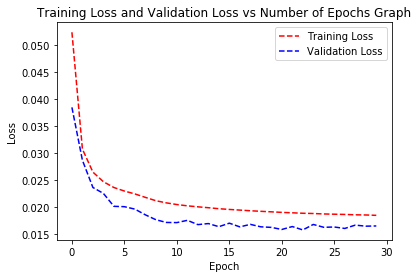

In [9]:
        def lossPlot():
            trainingLoss,=plt.plot(history_1.history['loss'],"r--")
            validationLoss,=plt.plot(history_1.history['val_loss'],"b--")
            q=plt.legend([trainingLoss,validationLoss],["Training Loss","Validation Loss"])
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Training Loss and Validation Loss vs Number of Epochs Graph")
            plt.show()
        lossPlot()

GMM Accuracy: 0.54

[[  0 217 662  42  24   0   1   6  44   4]
 [  0  22  43 922   9   0   0   0   4   0]
 [  0 310  38   3  90   0   0   1 552   6]
 [  0  91 404 476  16   0   0   1  11   1]
 [  0 120 151  15  78   0   0   0 631   5]
 [ 27   9   0   0   0  52 515 396   0   1]
 [  0 321 243  21  78   0   0   9 314  14]
 [  1   0   0   0   0 156 838   5   0   0]
 [  0 118  17   1 260   3  19 121  26 435]
 [361   6   1   0   2 574  27  29   0   0]]


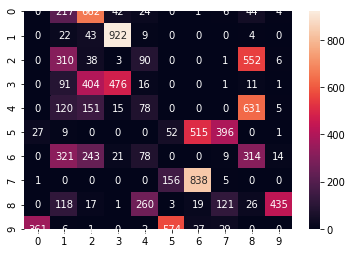

In [8]:
    #Guassian mixture model
    from sklearn.mixture import GaussianMixture
    import seaborn as sns

    gmm = GaussianMixture(n_components=10)
    gmm.fit(encoded_images)

    labelsGMM=gmm.fit_predict(encoded_images)

    def get_labels_GMM(gmm, actual_labels):

        inferred_labels = {}

        for i in range(gmm.n_components):
            labels = []
            index = np.where(labelsGMM == i)


            labels.append(actual_labels[index])

            if len(labels[0]) == 1:
                counts = np.bincount(labels[0])
            else:
                counts = np.bincount(np.squeeze(labels))


            if np.argmax(counts) in inferred_labels:

                inferred_labels[np.argmax(counts)].append(i)
            else:

                inferred_labels[np.argmax(counts)] = [i]

        return inferred_labels  

    def get_data_labels_GMM(X_labels, cluster_labels):

        predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)

        for i, cluster in enumerate(X_labels):
            for key, value in cluster_labels.items():
                if cluster in value:
                    predicted_labels[i] = key

        return predicted_labels
    cluster_labels_GMM = get_labels_GMM(gmm, y_test)
    predicted_Y_GMM = get_data_labels_GMM(labelsGMM, cluster_labels_GMM)

    print('GMM Accuracy: {}\n'.format(metrics.accuracy_score(y_test, predicted_Y_GMM)))
    cmGMM = confusion_matrix(y_test, labelsGMM)
    print(cmGMM)

    sns.heatmap(cmGMM,annot=True,fmt="d")